<div dir='rtl'>
<h1>پروژه چهارم</h1>
</div>

In [1]:
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import hazm

import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
STOP_WORDS_PATH = 'data/stopwords.txt'

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
display(train_df)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [4]:
label_counts = train_df['label'].value_counts()
label_counts = pd.DataFrame(label_counts)
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count'] # type: ignore
display(label_counts)

,label,count
0,فناوری,1500
1,ورزشی,1500
2,حوادث,1500
3,سلامت,1500
4,سیاسی,1500
5,فرهنگی/هنری,1500


<div dir='rtl'>
<h2>فاز اول: پیش‌پردازش داده</h2>
</div>

In [5]:
class TextNormalizer:
    def __init__(self, remove_stopwords: bool = True, lemmatize: bool = True, stem: bool = False, normalize: bool = False):
        self.remove_stopwords: bool = remove_stopwords
        self.lemmatize: bool = lemmatize
        self.stem: bool = stem
        self.normalize: bool = normalize

        self.normalizer: hazm.Normalizer = hazm.Normalizer()
        self.lemmatizer: hazm.Lemmatizer = hazm.Lemmatizer()
        self.stemmer: hazm.Stemmer = hazm.Stemmer()
        stopwords = hazm.stopwords_list(STOP_WORDS_PATH)
        self.stopwords: set[str] = set(self._stemAndLemmatize(word) for word in stopwords)
        self.stopwords.update(['\n', '\r', ' ', '\xa0'])

    def _stemAndLemmatize(self, text: str) -> str:
        text.replace('\u200c', ' ')
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        text = ' '.join(tokens)
        return text

    def normalize_text(self, text: str) -> str:
        if self.normalize:
            text = self.normalizer.normalize(text)
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stopwords]
        text = ' '.join(tokens)
        return text

    def add_stopwords(self, *words: str):
        self.stopwords.update(self._stemAndLemmatize(word) for word in words)

In [6]:
normalizer = TextNormalizer()
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df['content'] = df['content'].apply(normalizer.normalize_text)
    return df

In [7]:
train_df = normalize(train_df)
display(train_df)

,label,content
0,فناوری,گزارش منتشر حاکی کاربر تلگرام مناطق جهان اروپا...
1,ورزشی,سوپر استار سینما قهرمان ووشو ــ کونگ‌فو حضور ش...
2,حوادث,مدیرعامل شرکت عمران آب کیش فوت آتش‌سوزی بازار ...
3,فناوری,نوجوان انگلیسی اتهام هک کاربر ایمیل تلفن مقام ...
4,سلامت,دانشمند مطالعات اثرات ویروس کرونا گوش کشف گزار...
...,...,...
8995,حوادث,شانزدهم مهر تماس مرکز فوریت پلیس 110 کرمان درگ...
8996,ورزشی,اتحادیه فوتبال ترینیداد توباگو تیم ملی کشور تا...
8997,فرهنگی/هنری,اسامی 18 فیلم مسابقه ششمین دوره جشنواره فیلم ک...
8998,حوادث,کامیونت حامل تخته چوب عصر چهارشنبه برخورد حفاظ...


<div dir='rtl'>
1- 
عمل stemming برای حذف بخش‌های اضافی از کلمات به کار می‌رود برای مثال می‌توانیم به کمک انجام این کار، کلمه 
«کتاب ها»
را به 
«کتاب»
تبدیل کنیم. در اینجا از کتابخانه
hazm
استفاده می‌شود. دلیل استفاده از این روش این است که کلمه 
«کتاب»
با کلمه
«کتاب ها»
فرقی در شناسایی موضوع ایجاد نمی‌کند. البته این مورد با وجود سریع بودن، معمولا دقیق عمل نمی‌کند و ممکن است بخشی از کلمه را حذف کند به طوری که معنی کلمه کاملا تغییر کند.<br/><br/>
روش 
lemmatization
برای تبدیل افعال به بن مضارع/ماضی آن‌ها استفاده می‌شود. برای مثال کلمه
«می روم»
را به
«رفت#رو»
تبدیل می‌کند تا شخص افعال تفاوتی در موضوع ایجاد نکند. این مورد نسبت به 
stemming
بسیار دقیق‌تر اما کندتر است.
</div>

<div dir='rtl'>
<h2>فاز دوم: فرآیند مسئله</h2>
</div>

<div dir='rtl'>
در ابتدا به توضیح بیز می‌پردازیم:
</div>

$$P(c|x)=\dfrac{P(x|c)P(c)}{P(x)}$$
$$P(c|X)=P(x_1|c)\times P(x_2|c)\times ...\times P(x_n|c)\times P(c)$$

<div dir='rtl'>
x
را یک کلمه در نظر می‌گیریم و 
c
را یک کلاس در نظر می‌گیریم که در این قسمت کلاس‌ها در واقع موضوعات خبرها هستند. در نهایت می‌خواهیم به کمک قانون بیز، احتمال هر موضوع را با توجه به کلمه انتخابی پیدا کنیم و پس از محاسبه این احتمال برای تمام کلمات موجود در یک خبر، موضوع این خبر را پیدا کنیم.<br/><br/>
P(x)
یا 
Predictor Prior Probability
در واقع احتمال حضور یک کلمه در خبرها بدون توجه به موضوع آن‌ها است. این احتمال را می‌توانیم از نسبت تعداد دفعاتی که کلمه x
در کل خبرها به کار رفته به تعداد کل کلمات اخبار محاسبه کنیم.<br/>
P(c)
یا 
Class Prior Probability
احتمال اختصاص یک خبر به موضوع c
است. در این بخش می‌توانیم این احتمال را از نسبت تعداد خبرهای موضوع c
به تعداد کل خبرها محاسبه کنیم.<br/>
P(x|c)
یا
Likelihood
در واقع احتمال حضور کلمه x
در خبر با موضوع c
است که این احتمال را از تقسیم تعداد دفعاتی که x
در خبرهای با موضوع c
به کار رفته به تعداد کل کلمات اخبار گروه c
محاسبه می‌کنیم.<br/>
P(c|x)
یا
Posterior Probability
در واقع احتمال اختصاص خبر به موضوع c
است به شرطی که بدانیم کلمه x
در آن وجود دارد.<br/><br/>
به صورت کلی می‌توان گفت ما در ابتدا یک 
Prior Probability
داریم و به ازای مشاهده یک
Evidence
که در این قسمت کلمه x
است، می‌توانیم یک احتمال قوی‌تر یا
Posterior Probability
را محاسبه کنیم.
</div>

In [8]:
class Class:
    def __init__(self, name: str):
        self.name: str = name
        self.words: dict[str, int] = {}
        self.total_words: int = 0

    def train(self, words: list[str]):
        for word in words:
            self.words[word] = self.words.get(word, 0) + 1
            self.total_words += 1
    
    def get_probability(self, word: str) -> float:
        return self.words.get(word, 0) / self.total_words

    def plot_most_common_words(self, n: int = 5):
        words_counts = pd.DataFrame(self.words.items())
        words_counts.columns = ['word', 'count'] # type: ignore
        words_counts = words_counts.sort_values(by='count', ascending=False)
        words_counts = words_counts.head(n)
        persian_words = [get_display(reshape(word)) for word in words_counts['word']]
        plt.figure(figsize=(10, 5))
        plt.bar(persian_words, words_counts['count'], color='green', align='center', width=0.8)
        plt.xticks(rotation=45)
        plt.title(f'Most common words in {get_display(reshape(self.name))}')
        plt.show()

<div dir='rtl'>
به دلیل اینکه ضرب تعدادی احتمال کوچک می‌تواند باعث شود عدد نهایی تقریبا صفر شود، از لگاریتم در این بخش استفاده کردم و به جای ضرب احتمال‌ها در همدیگر، لگاریتم آن‌ها را جمع می‌کنیم.
</div>

In [9]:
class NaiveBayesClassifier:
    def __init__(self, classes: list[str], ngram: int = 1):
        self.classes: dict[str, Class] = {name: Class(name) for name in classes}
        self.subjects: dict[str, int] = {name: 0 for name in classes}
        self.total_subjects: int = 0
        self.ngram: int = ngram

    def train(self, df: pd.DataFrame):
        for index, row in df.iterrows():
            self.subjects[row['label']] += 1
            self.total_subjects += 1
            words = self._get_words(row['content'])
            self.classes[row['label']].train(words)

    def _get_words(self, text: str) -> list[str]:
        words = hazm.word_tokenize(text)
        if self.ngram > 1:
            words = self._get_ngrams(words)
        return words

    def _get_ngrams(self, words: list[str]) -> list[str]:
        ngrams = []
        for i in range(len(words) - self.ngram + 1):
            ngrams.append(' '.join(words[i:i + self.ngram]))
        return ngrams

    def classify(self, text: str, alpha: int = 0) -> str:
        words = self._get_words(text)
        probabilities = {}
        for name, subject in self.classes.items():
            probabilities[name] = math.log(self.subjects[name] / self.total_subjects)
            for word in words:
                val = (subject.get_probability(word) * subject.total_words + alpha) / (subject.total_words + alpha * len(subject.words))
                if val == 0:
                    val = 1e-100
                probabilities[name] += math.log(val)
        return max(probabilities, key=probabilities.get) # type: ignore

    def test(self, df: pd.DataFrame, alpha: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:
        df['predicted'] = df['content'].apply(lambda text: self.classify(text, alpha))
        return df, self._get_report(df)

    def _get_report(self, df: pd.DataFrame) -> pd.DataFrame:
        report = pd.DataFrame(columns=list(self.classes.keys()) + ['All Classes'], 
                              index=['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Macro Avg', 'Micro Avg', 'Weighted Avg']) # type: ignore 
        for name, subject in self.classes.items():
            tp = df[(df['label'] == name) & (df['predicted'] == name)].shape[0]
            fp = df[(df['label'] != name) & (df['predicted'] == name)].shape[0]
            fn = df[(df['label'] == name) & (df['predicted'] != name)].shape[0]
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1_score = 2 * precision * recall / (precision + recall)
            report[name]['Precision'] = precision
            report[name]['Recall'] = recall
            report[name]['F1-Score'] = f1_score
        report['All Classes']['Accuracy'] = df[df['label'] == df['predicted']].shape[0] / df.shape[0]
        report['All Classes']['Macro Avg'] = report.loc['F1-Score'].mean()
        report['All Classes']['Micro Avg'] = df[df['label'] == df['predicted']].shape[0] / df.shape[0]
        report['All Classes']['Weighted Avg'] = (report.loc['F1-Score'] * df['label'].value_counts() / df.shape[0]).sum()
        report = report.fillna('-')
        return report

    def plot_most_common_words(self, n: int = 5):
        for name, subject in self.classes.items():
            subject.plot_most_common_words(n)   

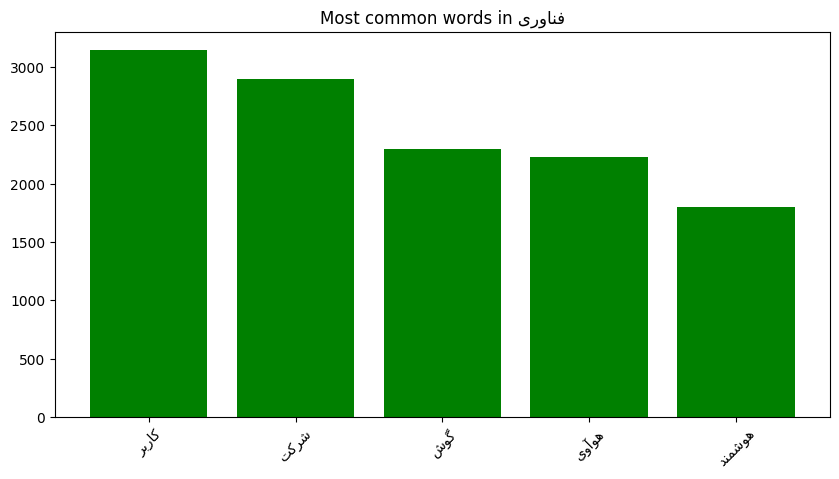

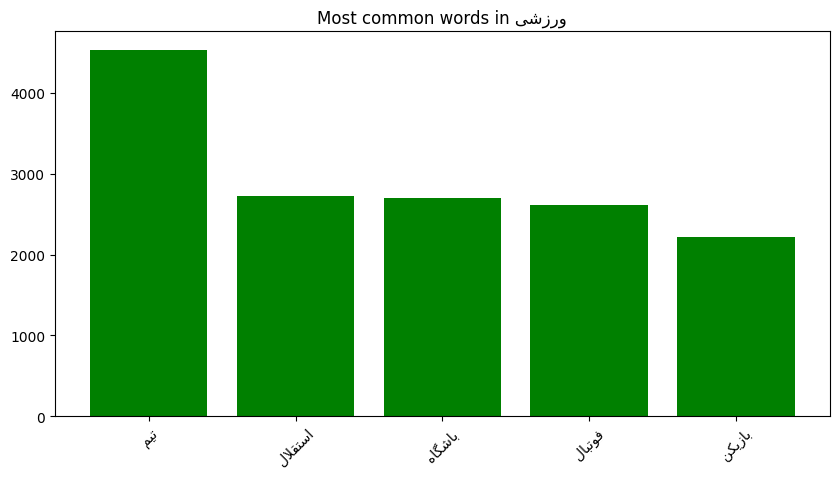

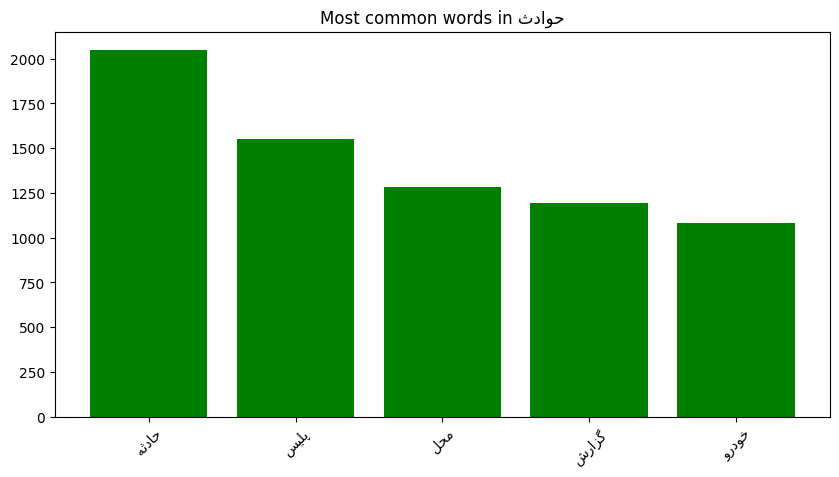

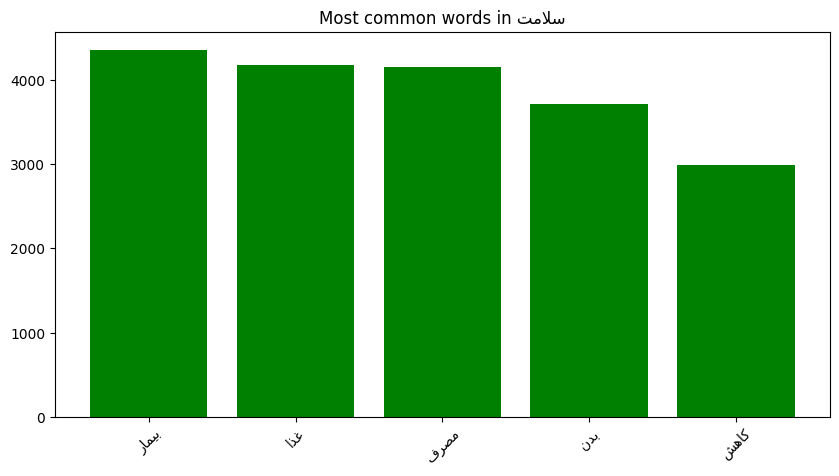

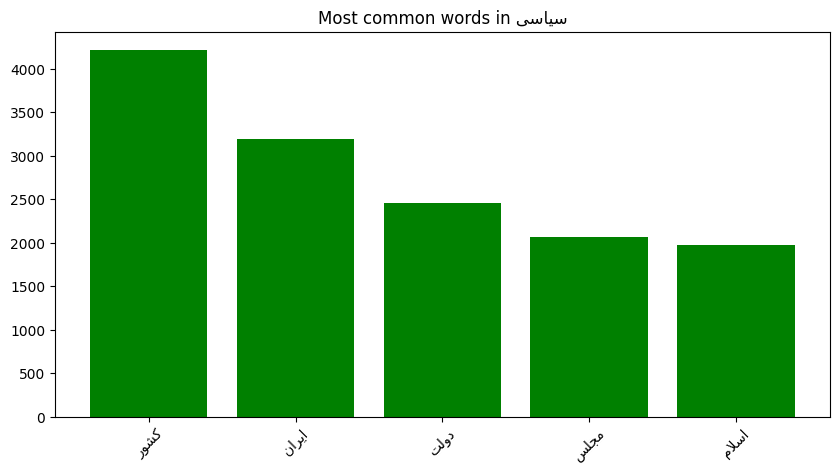

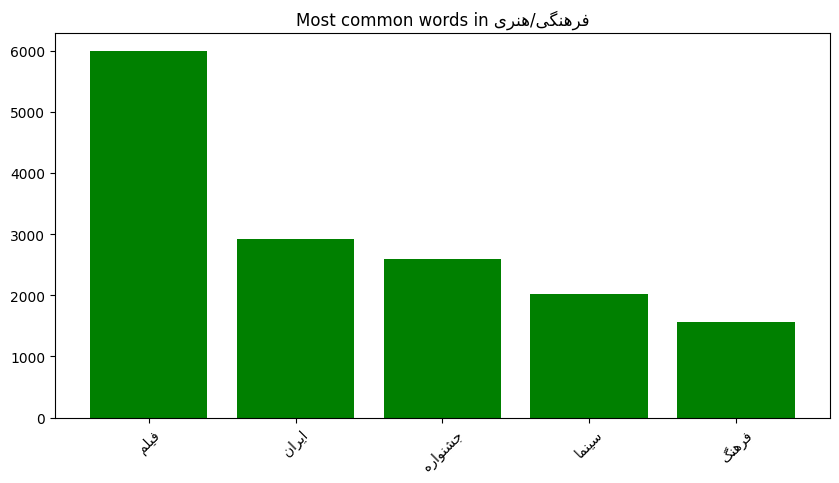

In [10]:
classifier = NaiveBayesClassifier(list(label_counts['label'])) # type: ignore
classifier.train(train_df)
classifier.plot_most_common_words()

<div dir='rtl'>
همانطور که مشاهده می‌شود، کلمه «گوش» که در فناوری به تعداد زیادی به کار رفته است، احتمالا کلمه «گوشی» بوده و به دلیل استفاده از
Lemmatization
به این کلمه تبدیل شده است.<br/>
از طرفی، کلمه ایران در چند موضوع پر استفاده است و به همین دلیل نمی‌تواند کمک زیادی به ما بکند.<br/>
کلمه اسلام نیز به دلیل استفاده زیاد در «جمهوری اسلامی» ممکن است باعث اشتباه شود.<br/><br/>
در نتیجه هر 3 کلمه را از خبرها حذف کردم تا در بررسی احتمالات تاثیر منفی نگذارند.
</div>

In [11]:
normalizer.add_stopwords("اسلام", "گوش", "ایران")

In [12]:
train_df = normalize(train_df)
display(train_df)

,label,content
0,فناوری,گزارش منتشر حاکی کاربر تلگرام مناطق جهان اروپا...
1,ورزشی,سوپر استار سینما قهرمان ووشو ــ کونگ‌فو حضور ش...
2,حوادث,مدیرعامل شرکت عمران آب کیش فوت آتش‌سوزی بازار ...
3,فناوری,نوجوان انگلیسی اتهام هک کاربر ایمیل تلفن مقام ...
4,سلامت,دانشمند مطالعات اثرات ویروس کرونا کشف گزارش خب...
...,...,...
8995,حوادث,شانزدهم مهر تماس مرکز فوریت پلیس 110 کرمان درگ...
8996,ورزشی,اتحادیه فوتبال ترینیداد توباگو تیم ملی کشور تا...
8997,فرهنگی/هنری,اسامی 18 فیلم مسابقه ششمین دوره جشنواره فیلم ک...
8998,حوادث,کامیونت حامل تخته چوب عصر چهارشنبه برخورد حفاظ...


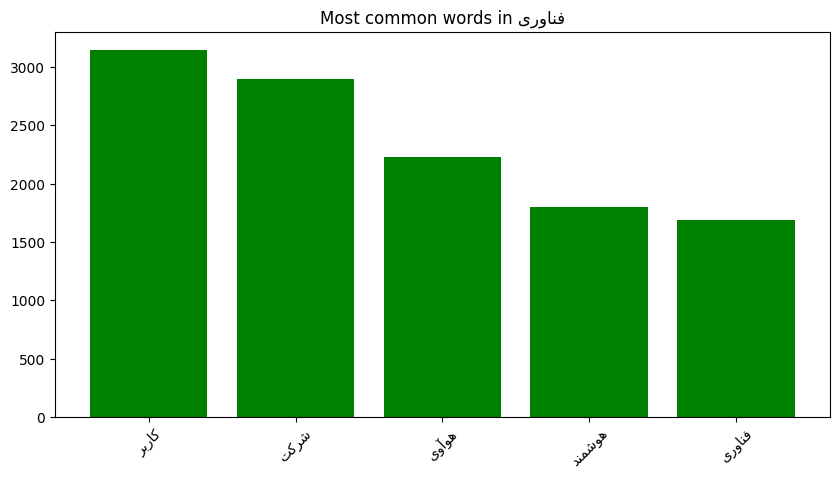

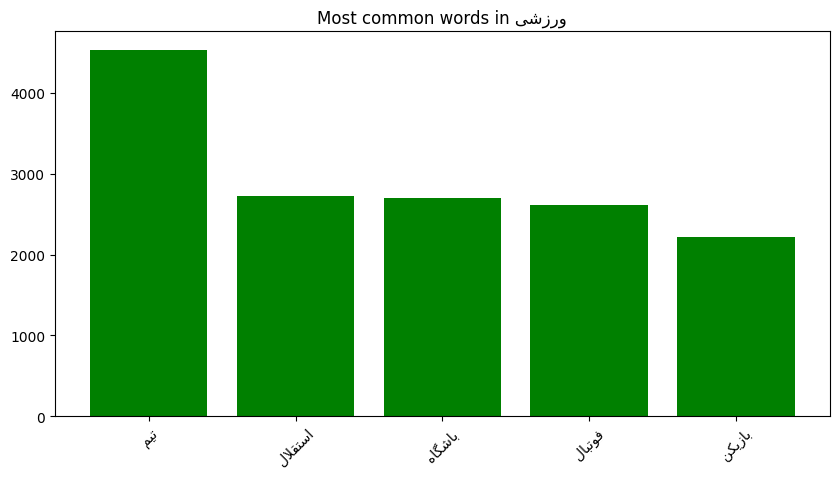

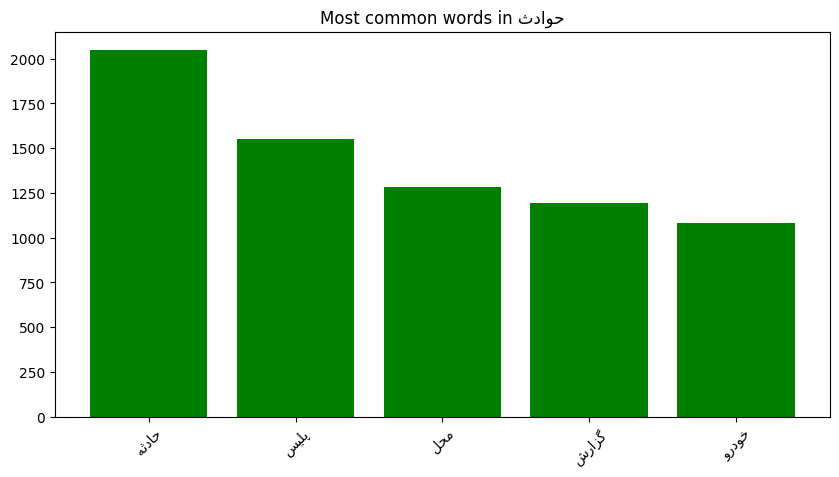

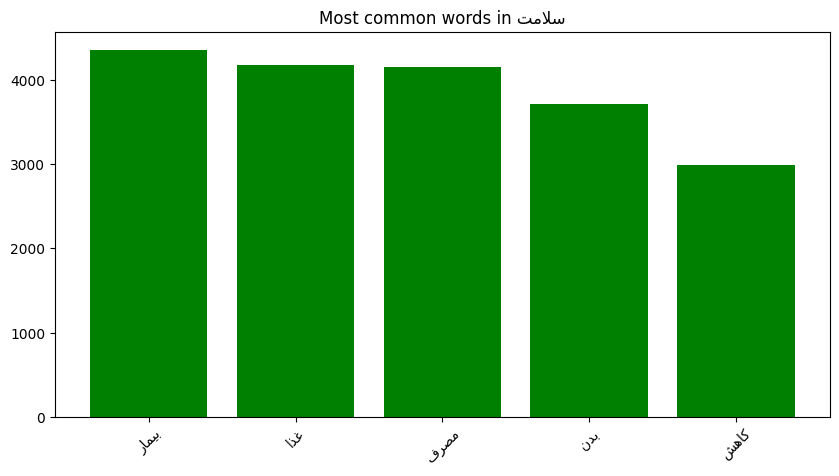

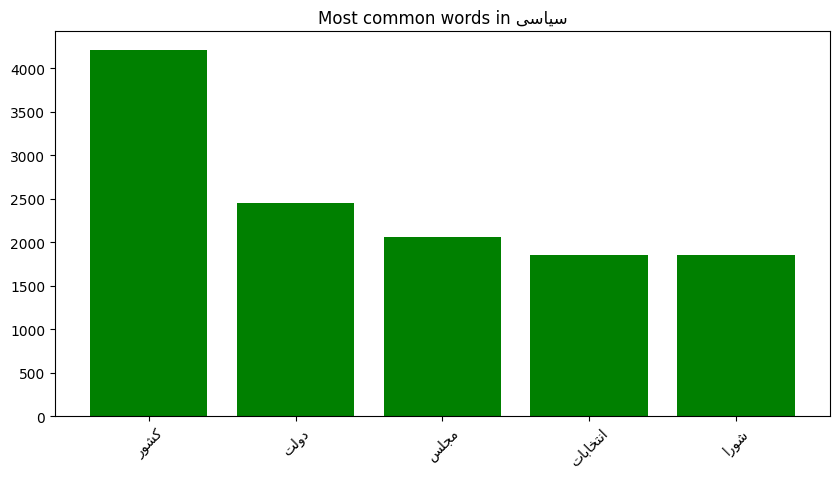

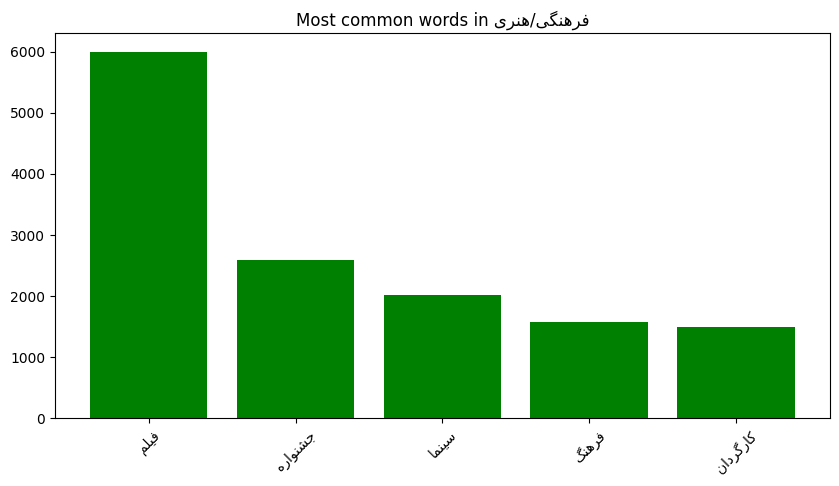

In [13]:
unigramClassifier = NaiveBayesClassifier(list(label_counts['label'])) # type: ignore
unigramClassifier.train(train_df)
unigramClassifier.plot_most_common_words()

<div dir='rtl'>
<h3>Bigrams</h3>
به دو جمله زیر دقت کنید:<br/>
- گربه شیر را خورد.<br/>
- شیر گربه را خورد.<br/><br/>
معنی این دو جمله کاملا متفاوت است. در جمله اول شیر به معنی «شیر خوراکی» و در جمله دوم به معنی «یک حیوان» است.<br/>
کلمات این دو جمله کاملا مشابه هم هستند و در 
Unigram
در کلاس یکسانی قرار می‌گیرند اما اگر کلمات را به صورت
Bigram
در نظر بگیریم، به کمک کلمه «را» در «شیر را» و «گربه را» می‌توانیم مفعول را تشخیص دهیم و با توجه به این مورد، معنی واقعی «شیر» 
را متوجه شویم و در این صورت ممکن است این دو جمله در کلاس‌های متفاوت قرار بگیرند.
</div>

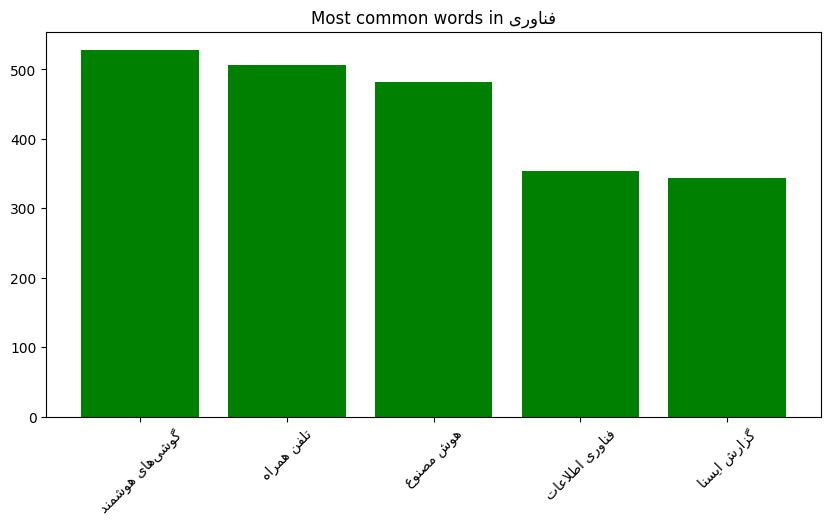

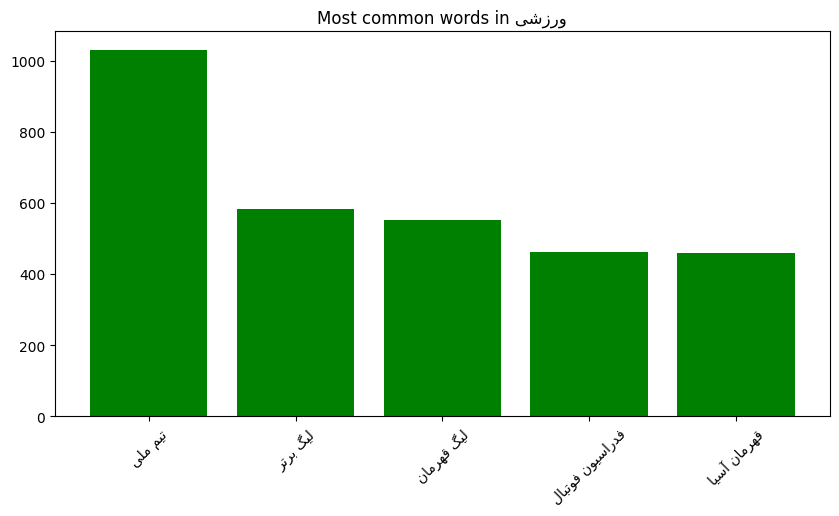

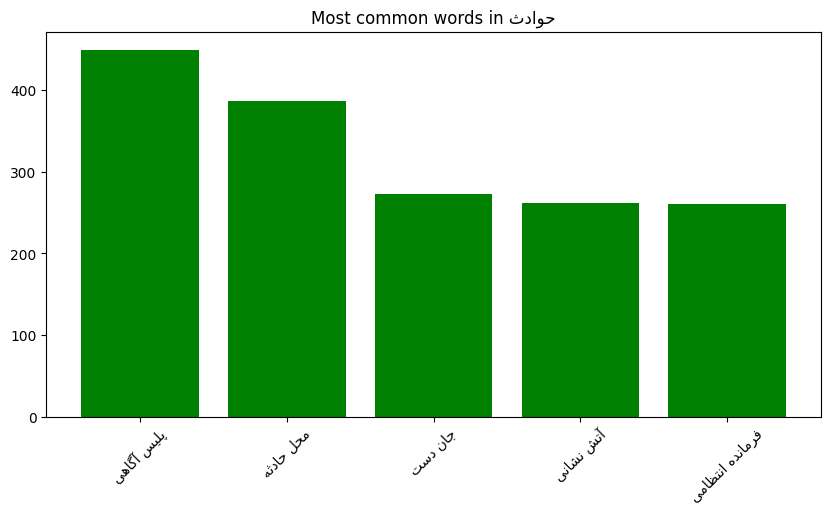

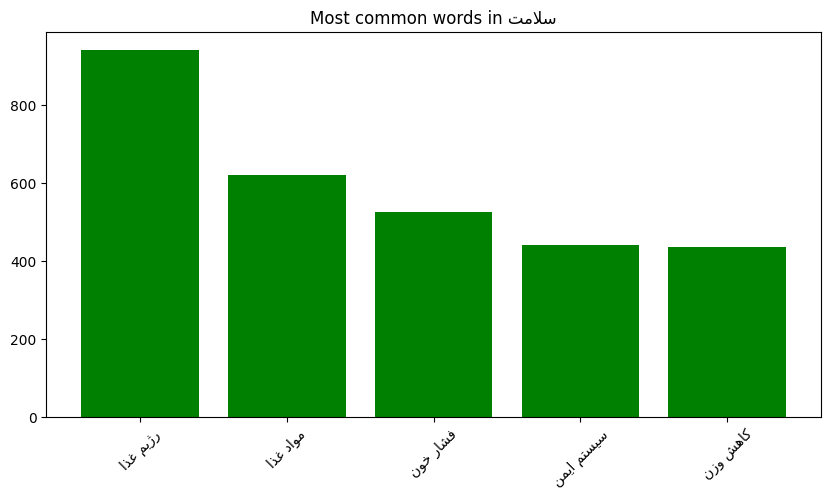

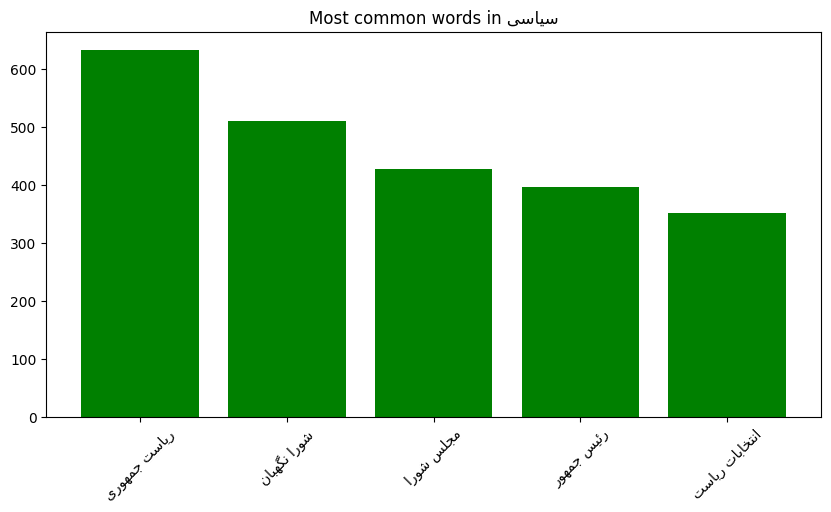

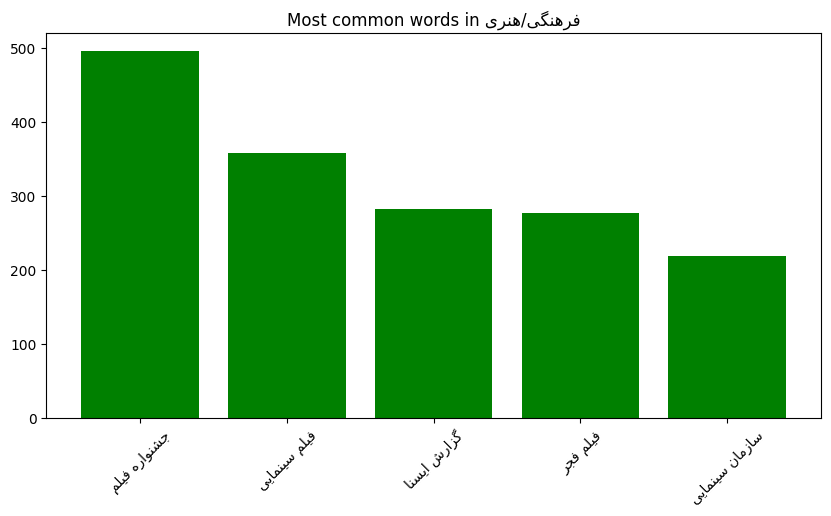

In [14]:
bigramClassifier = NaiveBayesClassifier(list(label_counts['label']), 2) # type: ignore
bigramClassifier.train(train_df)
bigramClassifier.plot_most_common_words()

<div dir='rtl'>
<h3>Additive Smoothing</h3>
4-
می‌دانیم احتمال نهایی (احتمال مطابقت هر کلاس به شرط کل کلمات خبر)، از ضرب احتمال هر کلمه به شرط کلاس محاسبه می‌شود. اگر یکی از کلمات خبر در کلاسی وجود نداشته باشد، احتمال نهایی صفر خواهد شد و اگر کلمه‌ای فقط در یک کلاس وجود داشته باشد، احتمال مطابقت تمام کلاس‌ها با این کلمه صفر می‌شود و فقط کلاسی که شامل این کلمه است، احتمالی بزرگ‌تر از صفر خواهد داشت و در نتیجه به صورت قطعی فقط این کلاس انتخاب می‌شود. در واقع عدم حضور یک کلمه خبر در کلاس صحیح، باعث می‌شود تمامی کلمات دیگر آن خبر شانس خود را از دست بدهند. برای مثال به فرمول زیر دقت کنید:
</div>

$$P(c|X)=P(x_1|c)\times P(x_2|c)\times ...\times P(x_n|c)\times P(c)$$

<div dir='rtl'>
فرض کنیم c
کلاس صحیح خبر X
باشد. اگر کلمه
x<sub>i</sub>
در کلاس c
نباشد، احتمال کلمات دیگر هیچ تاثیری نخواهند داشت و احتمال نهایی برابر با صفر خواهد شد.<br/><br/>
5-
برای حل این مشکل از تکنیک
Additive Smoothing
استفاده می‌شود. این تکنیک با افزودن یک مقدار ثابت به تعداد کلمات در کلاس، مشکل احتمال صفر را حل می‌کند. در واقع در این صورت احتمال نهایی همواره بزرک‌تر از صفر خواهد بود و بقیه کلمات خبر نیز می‌توانند شانس خود را حفظ کنند. این تکنیک به صورت زیر اعمال می‌شود:
</div>

$$P(x_i|c)=\dfrac{WordCount[c][x_i]+\alpha}{TotalWordCount[c]+\alpha\times UniqueWordCount[c]}> 0$$

<div dir='rtl'>
<h3>بررسی صحت</h3>
6-
این مورد در بخش‌های قبلی رسم شده است.
</div>

<div dir='rtl'>
<h2>فاز سوم: ارزیابی</h2>
7-
دو حالت زیر را برای یک کلاس خاص در نظر بگیرید:<br/>
- هیچ خبری را با این کلاس مطابقت ندهیم.<br/>
- تمام خبرها را با این کلاس مطابقت دهیم.<br/><br/>
در حالت اول، برای محاسبه 
Precision
به عبارت
<sup>0</sup>&frasl;<sub>0</sub>
می‌رسیم که با رفع ابهام به مقدار 1 (یعنی 100 درصد) می‌رسد. در صورتی که مقدار
Recall
در همین حالت برابر با 0 (یعنی 0 درصد) خواهد بود.<br/><br/>
در حالت دوم، برای محاسبه
Recall
به عبارت
<sup>n</sup>&frasl;<sub>n</sub>
می‌رسیم که n
تعداد خبرهای موجود در کلاس است. در این صورت مقدار 
Recall
برابر با 1 (یعنی 100 درصد) خواهد بود و در صورتی که مقدار
n
نسبت به تعداد کل خبرها بسیار کوچک باشد، مقدار
Precision
به 0 (یعنی 0 درصد) میل می‌کند.<br/><br/>
واضح است که هیچ کدام از این دو حالت مطلوب نیست در صورتی که در هر کدام از آن‌ها، یکی از معیارها برابر با 100 درصد است. با توجه به این مثال می‌توان نتیجه گرفت که معیارهای
Precision
و
Recall
باید به صورت متناظر با هم ارزیابی شوند و به تنهایی برای ارزیابی مناسب نیستند.<br/>
</div>

<div dir='rtl'>
8-
معیار
F1-Score
میانگین هارمونیکی از معیارهای
Precision
و
Recall
است. این معیار به صورت زیر محاسبه می‌شود:
</div>

$$F1-Score=\dfrac{2\times Precision\times Recall}{Precision+Recall}$$

<div dir='rtl'>
میانگین هارمونیکی نسبت به میانگین عادی در این مسئله بهتر عمل می‌کند. دلیل این مورد این است که اگر مقدار یکی از معیارها برابر با 0 و مقدار دیگری برابر با 1 باشد، مقدار میانگین عادی برابر با 0.5 خواهد بود در صورتی که مقدار میانگین هارمونیکی برابر با 0 خواهد بود. در واقع این میانگین نسبت به مقادیر بسیار کوچک، حساسیت بیشتری از خود نشان می‌دهد.<br/>
دلیل استفاده از این معیار این است که ما می‌خواهیم هر دو معیار را بالا (و تا جای ممکن نزدیک به هم) نگه داریم که بالا بودن 
F1-Score
این مورد را تضمین می‌کند.
</div>

<div dir='rtl'>
9-
معیار
Macro-Avg
صرفا میانگین معیارهای
F1-Score
برای هر کلاس است که باعث می‌شود یک دید کلی نسبت به مقادیر
F1-Score
هر کلاس داشته باشیم.<br/><br/>
معیار
Weighted-Avg
میانگین وزن‌دار معیارهای
F1-Score
برای هر کلاس است به طوری که وزن هر کلاس، تعداد نمونه‌های آن کلاس است که برای 
test
شدن استفاده شده است.<br/><br/>
معیار
Micro-Avg
به این صورت است که ابتدا مقادیر
Micro-Precision
و
Micro-Recall
محاسبه می‌شوند و سپس از آن‌ها مقدار
Micro-Avg
محاسبه می‌شود. در این معیار تمامی نمونه‌ها و پیش‌بینی ها را در کنار هم در نظر می‌گیریم. مقادیر
Micro-Precision
و
Micro-Recall
به صورت زیر محاسبه می‌شوند:
</div>

$$Micro-Precision=\dfrac{TP}{TP+FP}$$
$$Micro-Recall=\dfrac{TP}{TP+FN}$$

<div dir='rtl'>
با توجه به اینکه همه پیش‌بینی‌ها را در کنار هم در نظر می‌گیریم، هر پیش‌بینی درست یک
TP
و هر پیش‌بینی اشتباه یک
FP و FN
خواهد بود. برای مثال اگر کلاس 
A
را اشتباها در کلاس
B
پیش‌بینی کنیم، یک
FP
برای کلاس
B
و یک
FN
برای کلاس
A
خواهیم داشت. در نتیجه مقادیر
Micro-Precision
و
Micro-Recall
یکسان خواهند بود. از طرفی مقدار
Accuracy
نیز برابر با همین مقادیر خواهد بود.
</div>

$$Micro-Avg=Micro-Precision=Micro-Recall=Accuracy$$

In [15]:
test_df = pd.read_csv(TEST_PATH)
test_df = normalize(test_df)
display(test_df)

,label,content
0,فناوری,لیس ۲۳ شرکت مجاز ثبت سفارش ارائه فروش تلفن همر...
1,فرهنگی/هنری,استاد علم قرائت قرآن کریم ریشه موسیقی مقام عرب...
2,حوادث,آتش سوخت#سوز زنجیره جنگل زاگرس استان ایلام کهگ...
3,فناوری,سرویس‌های iMassage Facetime محصولات شرکت اپل د...
4,حوادث,دادستان انقلاب یاسوج 10 دلار جعلی خودرو شهرستا...
...,...,...
1110,ورزشی,عضو هیات مدیره باشگاه استقلال مدیرعامل پست است...
1111,حوادث,مدیر آموزش پرورش شهرستان جیرفت دستگیر دانش آمو...
1112,سیاسی,رییس جمهور هفته شهر قرمزی کشور خوزستان شهر قرم...
1113,فناوری,دارندگان مدل‌های اعلام‌شده گوشی‌های هوآوی به‌ر...


<div dir='rtl'>
10- 
جدول معیارها برای هر حالت در بخش زیر آورده شده است:
</div>

<div dir='rtl'>
<h4>حالت Unigram بدون Additive Smoothing:</h4>
</div>

In [16]:
resUniWithoutSmoothing, reportUniWithoutSmoothing = unigramClassifier.test(test_df)
display(reportUniWithoutSmoothing)

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,0.90184,0.982353,0.939759,0.946108,0.782222,0.714286,-
Recall,0.875,0.878947,0.78,0.892655,0.88,0.888889,-
F1-Score,0.888218,0.927778,0.852459,0.918605,0.828235,0.792079,-
Accuracy,-,-,-,-,-,-,0.864574
Macro Avg,-,-,-,-,-,-,0.867896
Micro Avg,-,-,-,-,-,-,0.864574
Weighted Avg,-,-,-,-,-,-,0.867089


<div dir='rtl'>
<h4>حالت Bigram بدون Additive Smoothing:</h4>
</div>

In [17]:
resBiWithoutSmoothing, reportBiWithoutSmoothing = bigramClassifier.test(test_df)
display(reportBiWithoutSmoothing)

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,0.935673,0.989305,0.950249,0.955307,0.908654,0.946746,-
Recall,0.952381,0.973684,0.955,0.966102,0.945,0.888889,-
F1-Score,0.943953,0.981432,0.952618,0.960674,0.926471,0.916905,-
Accuracy,-,-,-,-,-,-,0.947085
Macro Avg,-,-,-,-,-,-,0.947009
Micro Avg,-,-,-,-,-,-,0.947085
Weighted Avg,-,-,-,-,-,-,0.947046


<div dir='rtl'>
<h4>حالت Unigram با Additive Smoothing:</h4>
</div>

In [18]:
resUniWithSmoothing, reportUniWithSmoothing = unigramClassifier.test(test_df, 1)
display(reportUniWithSmoothing)

,فناوری,ورزشی,حوادث,سلامت,سیاسی,فرهنگی/هنری,All Classes
Precision,0.95122,0.989305,0.898148,0.971264,0.9,0.969512,-
Recall,0.928571,0.973684,0.97,0.954802,0.945,0.883333,-
F1-Score,0.939759,0.981432,0.932692,0.962963,0.921951,0.924419,-
Accuracy,-,-,-,-,-,-,0.943498
Macro Avg,-,-,-,-,-,-,0.943869
Micro Avg,-,-,-,-,-,-,0.943498
Weighted Avg,-,-,-,-,-,-,0.943606


<div dir='rtl'>
همانطور که مشاهده می‌شود، معیارهای
Macro-Avg
و
Accuracy
در این حالت، بیشتر از 90 درصد هستند.<br/><br/>
11-
در حالت بدون 
Additive Smoothing
همانطور که پیش‌تر توضیح داده شد، ممکن است به دلیل عدم وجود یکی از کلمات، مقدار احتمال برابر با 0 شود و خبر به موضوع غیر مرتبطی اختصاص داده شود و به همین دلیل بعضی از معیارها پایین‌تر از حد انتظار است. اما در حالت
Additive Smoothing
به دلیل افزودن مقدار ثابتی به تعداد کلمات، احتمال نهایی برای هر کلاس، بیشتر از صفر است و به همین دلیل 
Classification
عملکرد بهتری دارد.
</div>

In [19]:
wrongUniWithSmoothing = resUniWithSmoothing[resUniWithSmoothing['label'] != resUniWithSmoothing['predicted']]
pd.set_option('display.max_rows', None)
display(wrongUniWithSmoothing)

,label,content,predicted
30,فرهنگی/هنری,چهارشنبه تیر 1401 اتفاق نادر جالب تصادف برنامه...,سیاسی
45,فرهنگی/هنری,اعتراض گسترده کاربر اظهارات وزیر امورخارجه آمر...,سیاسی
74,سیاسی,وکیل مدافع نازنین زاغری متهم بریتانیایی برگزار...,حوادث
85,فرهنگی/هنری,معرف ساپینتو مربی باشگاه استقلال مصطفی آجورلو ...,ورزشی
88,سلامت,وزیر بهداشت نامه معاون بهداشت وزارتخانه دستور ...,سیاسی
136,سیاسی,سخنگو وزارت خارجه اخبار منتشر رسانه پاکستان چگ...,حوادث
141,فرهنگی/هنری,عصرخبر,فناوری
143,فناوری,بحبوحه افزایش درخواست حذف لاین انتشار پست دونا...,سیاسی
149,فرهنگی/هنری,12 اردیبهشت معلم سال‌روز ترور استاد شهید مرتضی...,سیاسی
167,سیاسی,وکیل مدافع نازنین زاغری برگزاری جلسه رسیدگی ات...,حوادث


<div dir='rtl'>
12-
همانطور که مشاهده می‌شود، اکثر خبرهایی که موضوعشان غلط تشخیص داده شده، مربوط به موضوع‌های «سیاسی»، «حوادث» و یا «فرهنگی/هنری» هستند. علت این مورد این است که احتمالا تعدادی از کلمات در همه این موضوعات به وفور یافت می‌شوند. احتمالا با تغییر در بخش پیش‌پردازش بتوانیم این مشکل را بهبود ببخشیم. برای مثال می‌توانیم نمودار کلمات پرتکرار را برای تعداد بیشتری کلمه (n) رسم کنیم و کلمات پر تکرار در تمام این بخش‌ها را نیز به 
Stopwords
اضافه کنیم.
</div>